In [15]:
#fmain
import numpy as np
import os
import pandas as pd
import pprint

from matplotlib import cm
import pycircos

import fconfig as cfg
# pip show pycircos - location of package
# /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pycircos/pycircos.py
DBG = False
DBG1 = False

COLOR_DICT = {}
for key in cfg.color_names.keys():
    COLOR_DICT[key] = cfg.color_names[key][0]

In [16]:
class ColorDict:
    def __init__(self):
        # Create dict with key = network #
        self.color_dict = {}

    def get_matplot_colors(self,colormap_name,num):
        color_map = cm.get_cmap(colormap_name, num)
        for i in range(color_map.N):
            rgba = color_map(i)
            self.color_dict[i] = cm.colors.rgb2hex(rgba)
        return self.color_dict

    def print_map(self,name,num):
        return cm.get_cmap(name,num)

# TEST
# ColorDict().get_matplot_colors('rainbow',4)   
# ColorDict().print_map('rainbow',15)  
# ColorDict().print_map('viridis',15)    

In [17]:
def print_slice(label,d,num):
    print(label," First", num, dict(list(d.items())[:num]))

class NodeData:
    def __init__( self, parts:list, nodes:list, sheet_matrix:str,
                  nets:list ):
        ''' generates data structure used to draw arcs/lines
            REQUIRES:
            src = (part, abs_col)
            dest = (part, abs_col)
            color = network
        '''
        # read in matrix sheet 
        self.dest_node_dict = self.read_matrix_sheet(sheet_matrix )
  
        # create dict of nodes node:part,abs_col
        self.src_node_dict = self.create_part_node_map(parts,nodes)

        # create mapping of node to network (used for colors)
        self.node_net_map = self.create_node_net_map(nodes,nets)

        # generate list of src and dest nodes
        self.nodes_list = self.create_nodes_list(self.node_net_map)
        
        if DBG:
            print_slice( "\nMatrix Nodes:", dict(list(self.dest_node_dict.items())[:5]))
            print_slice("Src Nodes:",self.src_node_dict,10)
            print("Nodes Arcs:\n",self.nodes_list[:5])


    def read_matrix_sheet(self,sheet_matrix):
        # returns list of columns numbers of first non-zero node
        
        self.matrix_df = pd.DataFrame(pd.read_excel(cfg.Ginput_file,
                sheet_name=sheet_matrix,))
        
        nonzero = np.argmax(self.matrix_df.values!=0,axis=0) #axis=0 is colum
        # skip header
        nonzero = nonzero[1:]
        # # cols are zero-based so add 1 to each 
        # nodes = [ a+1 for a in nonzero]
        # print(nodes)
        n = 1 # list is zero based
        d = {}
        for col in nonzero:
            d[n] = {
                'col':col+1,
                'dest_node':col+1,
                }
            n+=1
        return d

    def create_part_node_map(self,parts,nodes):
        ''' returns a dict of key=node
        and items = (partition, partition_start_col)
        ''' 
        d = {}
        for col,(node,part) in enumerate(zip(nodes,parts)):
            # print(col+1,node,part)
            # d[node] = [part,col+1]
            d[node] = {
                'src_node':node,
                'part':part,
                'src_col':col+1,
            }
        # pprint.pp(node_dict)
        return d

    def create_node_net_map(self, nodes,nets):
        ''' give node get network'''
        d = {}
        for node,net in zip(nodes,nets):
            # print(col+1,node,part)
            # d[node] = [part,col+1]
            d[node] = {
                'node':node,
                'net':net,
            }

        return d   

    def create_nodes_list(self,node_net_dict:dict):
        ''' returns part, src_node 
        part src_node_col   dest_node_col  node_num
        '''
        rows = []
        s = self.src_node_dict
        d = self.dest_node_dict

        for node in s.keys():
            part = s[node]['part']
            src_node_col = s[node]['src_col']
            src_end = src_node_col +cfg.CHORD_WIDTH

            dest_node = d[node]['dest_node']
            dest_node_col = s[dest_node]['src_col']
            dest_end = dest_node_col +cfg.CHORD_WIDTH

            rows.append( (part,
                        src_node_col, src_end,
                        dest_node_col, dest_end,
                        node,
                        node_net_dict[node]['net']
                        ))
            if DBG:
                print(f'Partition {part} Node {node}->{dest_node}  ({node},{src_node_col}) ({dest_node},{dest_node_col})')
        return rows


In [18]:
class DataList:
    def __init__(self, dfs, sheet, sheet_matrix ):
        self.sheet = sheet 
        self.parts_skip = []

        # Get the dataframe for this sheet
        #   sort by Partition (row=2) and then Network (row=0)
        #   ex: Blast - Sort by '751 blast' 
        #   must drop Column 0 bc it contains strings and sort can only sort same type
        df = dfs[self.sheet]
        df = df.drop(columns=[0])
        self.sheet_df = df.sort_values(by=[2,0], axis=1)

        # create sorted file for debugging
        self.create_sorted_csv()

        # 0,1,2 are rows to read in as a list, then remove index at col=0 
        self.netw_list = list(self.sheet_df.to_records()[0])[1:] 
        self.nodes_list = list(self.sheet_df.to_records()[1])[1:] 
        self.part_list = list(self.sheet_df.to_records()[2])[1:] 
        self.cols_list = list(range(1,len(self.netw_list)+1))

        # map data 
        self.part_map = self.create_partition_map()
        self.node_obj = NodeData( self.part_list, self.nodes_list,
                                  sheet_matrix, self.netw_list )
    
    def get_nodes_list(self):
        return self.node_obj.nodes_list

    def create_sorted_csv(self):
        #  DEBUG, create sorted CSV
        filename = self.sheet+'_sorted.csv'
        self.sheet_df.to_csv( filename )
        print(f'\n{"Overwrite" if os.path.exists(filename) else "Created"}: {filename}')


    def create_partition_map(self):
        if DBG:
            print('Uniq Partitions:',list(set(self.part_list)))

        part_list = self.part_list
        netw_list = self.netw_list

        pdict = self.build_start_stop( part_list,netw_list)

        # get network abs cols and put part in there for printint
        for p in pdict.keys():
            pdict[p]['partid']=str(p)
            pdict[p]['rel_nets'] = self.build_start_stop(pdict[p]['nets'],None )
            # pprint.pp( pdict )
            if pdict[p]['len']==1:
                self.parts_skip.append(p)

        #BRITT GENERATE REL/ABS
        for p in pdict.keys():
            rn = pdict[p]['rel_nets'] 
            pdict[p]['net_row'] = []
            for n in rn:
                pdict[p]['net_row'].append( (p, rn[n]['start'],rn[n]['end'],
                                                rn[n]['len'], n ))
            # pprint.pp( pdict )
            # return
        if DBG:
            print("create_partition_map")
            pprint.pp(pdict )
        if self.parts_skip:
            print(f'{self.sheet} Partitions with 1 Network: {self.parts_skip}')
        return pdict

    def get_rel_rows(self, pdict):
        rows = []
        for p in pdict.keys():
            a = pdict[p]['net_row']
            for b in a:
                rows.append( b )
        # print(" NETWORKS WITH REL COLS")
        return rows

    def build_start_stop(self,vals,nets=None):
        d = {}
        ct = 0
        for v in vals:
            if v not in d.keys():
                d[v]={}
                d[v]['start'] = ct
                if nets:
                    d[v]['nets'] = []
            if nets:
                d[v]['nets'].append(nets[ct])
            d[v]['end']=ct 
            d[v]['len']=d[v]['end']-d[v]['start']+1
            ct+=1
        return d   


In [19]:

class ReadExcelFile:
    def __init__(self,input_file):
        ''' Generate the csv files for this excel file.
            Notes: 
                1. header=None will read in ALL SPREADSHEETS
                with this setting.
                Matrix Spreadsheet HAS a header so must be read in separately.
                Sorting will Fail if there is a header for subject sheet
                
                2. Nonblast Sheetname has trailing SPACE in name.
        '''

        self.dfs = pd.read_excel(
            input_file,
            sheet_name=None, # READS ALL WORSHEETS
            header=None)
        # sheets are in pairs, first is subject, second is matrix
        
        self.sheet_list = list(zip(list(self.dfs.keys())[::2],list(self.dfs.keys())[1::2]))
        print(f"Opened File: {input_file}\n Sheets:{self.sheet_list}")

        self.data_dict = {}

    def process_sheets(self,debug_flag=False):
        for sub_sheet, matrix_sheet in self.sheet_list:
            self.data_dict[sub_sheet] = DataList( self.dfs, sub_sheet, matrix_sheet)
            if debug_flag:
                print("Testing: Only processing: ",sub_sheet)
                return

    def draw_all(self):
        for sheet in self.data_dict.keys():
            data_obj = obj.data_dict[sheet]
            cir = ChordCircle(sheet)
            cir.plot_it( data_obj.part_map, data_obj.get_nodes_list())
    
        

In [20]:
class ChordCircle:
    def __init__(self,title):
        self.title = title
    
    def plot_it(self,part_dict, nodes_list):
        ''' REQUIRES: 
                    PARTID, 
                    LEN_OF_PART
        '''
        self.part_dict = part_dict

        # partition colors
        color_dict = ColorDict().get_matplot_colors('rainbow',
                        len(part_dict.keys())+1)
        # plot circle
        self.circ = pycircos.Gcircle() 

        for partid in part_dict.keys():
            # partid MUST be a STRING
            p = part_dict[partid]
            length = p['len']
            if length>1: # or (length==1 and not SKIP_LENGTH_1):
                arcc = pycircos.Garc(arc_id=str(partid), size=length, 
                                interspace=2, raxis_range=(950,1000), 
                                facecolor=color_dict[partid],
                                labelsize=20,
                                labelposition=60, label_visible=True)
            self.circ.add_garc(arcc) 
        self.circ.set_garcs(0,360) # this displays the circle

        self.draw_netw(self.circ,part_dict)
        self.draw_arcs(self.circ,nodes_list)

        self.circ.figure.suptitle("\n\n"+self.title, fontsize=30)

    def draw_netw( self, circ ,part_dict):
        # draw_networks
        # WARNING!!!! HAS TO BE IN SAME FUNCTION OR WON"T DRAWR BARS
        ''' REQUIRES: 
                    part,
                    number of networks, 
                    network start col within part
                    width of network
                    network id = color
        '''

        # Use CUSTOM COLOR MAP
        # color_dict = ColorDict().get_matplot_colors('viridis',15) # FOR NOW
        color_dict = COLOR_DICT

        for partid in part_dict.keys():
            # partid MUST be a STRING
            p = part_dict[partid]
            # print('Part:',p['partid'],'Part Len=',p['len'],"\nNetwork\n")
            length = p['len']
            if length>1: # or (length==1 and not SKIP_LENGTH_1):
            #     # print("col_start,net_width,net")
                for netw in p['rel_nets'].keys():
                    n = p['rel_nets'][netw]
                    # print(p['partid'],n['start'],n['len'],netw)
                    # return
                    circ.barplot( p['partid'], 
                            data = [1], 
                            positions = [n['start']], 
                            width = [n['len']],
                            raxis_range=[950,1000], 
                            facecolor = [ color_dict[netw] ]
                    )

    def draw_arcs(self, cir, nodes:list):
        # print("draw_arcs ARCS # of nodes",len(nodes))

        # skip nodes in partitions of length 1
        skip_nodes = []
        rows = []
        for p,s,sw,d,dw,n,net in nodes:
            if self.part_dict[p]['len'] >1:
                rows.append((p,s,sw,d,dw,n,net))
            else:
                skip_nodes.append((p,n))

        print(f'\n({self.title})',"Nodes#:",len(nodes),'Skipping:',len(skip_nodes),
                'Plotting:',len(rows))

        for p,s,sw,d,dw,n,net in rows:
            src = (str(p),s,sw,1000)
            dest = (str(p),d,dw,1000)
     
            # print("ARC",src,dest,net)
            color = COLOR_DICT[net]
            self.circ.chord_plot(src, dest, facecolor=color)
 
    def draw_partitions_only(self,part_dict,SKIP_LENGTH_1=False):
        ''' REQUIRES: 
                    PARTID, 
                    LEN_OF_PART
        '''
        # partition colors
        color_dict = ColorDict().get_matplot_colors('rainbow',
                        len(part_dict.keys())+1)
        # plot circle
        self.circ = pycircos.Gcircle() 

        for partid in part_dict.keys():
            # partid MUST be a STRING
            p = part_dict[partid]
            length = p['len']
            if length>1 or (length==1 and not SKIP_LENGTH_1):
                arcc = pycircos.Garc(arc_id=str(partid), size=length, 
                                interspace=2, raxis_range=(950,1000), 
                                facecolor=color_dict[partid],
                                labelsize=20,
                                labelposition=60, label_visible=True)
            self.circ.add_garc(arcc) 
        self.circ.set_garcs(0,360) # this displays the circle          
        self.circ.figure.suptitle("\n\n"+self.title+"\nPartitions", 
                fontsize=30)   


Opened File: Partitions_new.xlsx
 Sheets:[('Blast', 'Blast matrix'), ('Nonblast ', 'Nonblast matrix'), ('Controls', 'Control matrix')]

Overwrite: Blast_sorted.csv
Blast Partitions with 1 Network: [4, 5, 14, 15, 18, 19]

Overwrite: Nonblast _sorted.csv
Nonblast  Partitions with 1 Network: [2, 5, 9, 13, 14, 15, 17, 19, 21]

Overwrite: Controls_sorted.csv
Controls Partitions with 1 Network: [3, 11, 12, 13, 14, 17, 21, 22, 23, 25, 26, 27, 28, 29, 30]
(
Blast) Nodes#: 264 Skipping: 6 Plotting: 258
(
Nonblast ) Nodes#: 264 Skipping: 9 Plotting: 255
(
Controls) Nodes#: 264 Skipping: 15 Plotting: 249


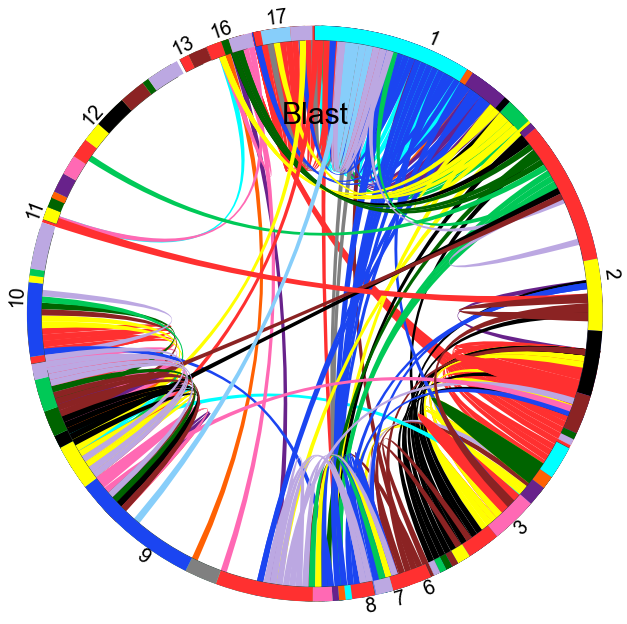

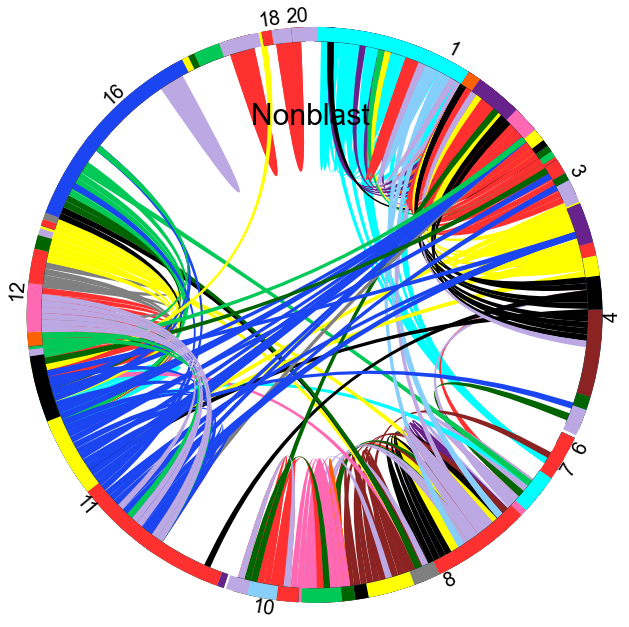

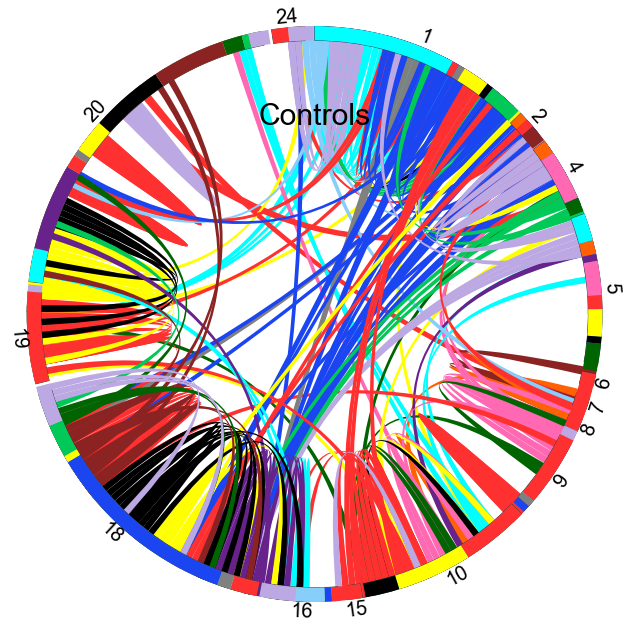

In [21]:
DBG = False
SHEET = 'Blast'

obj = ReadExcelFile( cfg.Ginput_file )
obj.process_sheets() 
obj.draw_all()


In [22]:
# # TESTING CODE
def test_one_sheet():
    obj = ReadExcelFile( cfg.Ginput_file )
    obj.process_sheets() 
    data_obj = obj.data_dict[SHEET]


    # draw part
    cir = ChordCircle(SHEET)
    cir.plot_it( data_obj.part_map, data_obj.get_nodes_list())

In [23]:
# TESTING ONLY
#  cir.draw_partitions_only( data_obj.part_map, SKIP_LENGTH_1=False)


In [24]:
# cir.draw_networks( data_obj.part_map, SKIP_LENGTH_1=False)